In [20]:
import numpy as np
import pandas as pd
import tqdm
from PIL import Image
import skimage.io
import math
import matplotlib.pyplot as plt
import os
import cv2
import sys

sys.path.append('../')

from config import Config
from util import DataManager

def mask_penmarks(image_rgb,
                  kernel_size=(5, 5),
                  r_threshold=220,
                  r_std_multiplier=0.25,
                  contour_threshold=64):

    # Define elliptic kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)

    # Compute parameters for upper bound of cv2.inRange
    image_r = image_rgb[..., 0]
    image_r = image_r.reshape(-1)
    image_r = image_r[np.where(image_r < r_threshold)[0]]
    image_r_mean = image_r.mean()
    image_r_std = image_r.std()

    # Now use cv2.inRange to mask pen marks
    r_upper = int(image_r_mean - image_r_std*r_std_multiplier)
    lower = np.array([0, 0, 0])
    upper = np.array([r_upper, 255, 255])
    mask1 = cv2.inRange(image_rgb, lower, upper)

    # Use erosion and findContours to remove masked tissue (side effect of above)
    mask1 = cv2.erode(mask1, kernel, iterations=4)
    # Initialize mask2 which will be drawn on and become new mask for pen marks
    mask2 = np.zeros(mask1.shape, dtype=np.uint8)
    contours, _ = cv2.findContours(mask1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y = contour[:, 0, 0], contour[:, 0, 1]
        w, h = x.max()-x.min(), y.max()-y.min()
        if w > contour_threshold or h > contour_threshold:
            cv2.drawContours(mask2, [contour], 0, 1, -1)
    mask2 = cv2.dilate(mask2, kernel, iterations = 15)
    mask2 = 1 - mask2
    return mask2

def read_image(img_path):
    image = Image.open(img_path)
    image = np.array(image)
    return image

def remove_penmarks(img_path):
    image = read_image(img_path)
    mask = mask_penmarks(image)
    image_masked = np.where(mask[...,np.newaxis] == 0, 255, image)
    return image_masked

def save_masked_image(img_path):
    img_masked = remove_penmarks(img_path)
    img_masked = Image.fromarray(img_masked)
    #img_masked.save(img_path, subsampling=0, quality=10

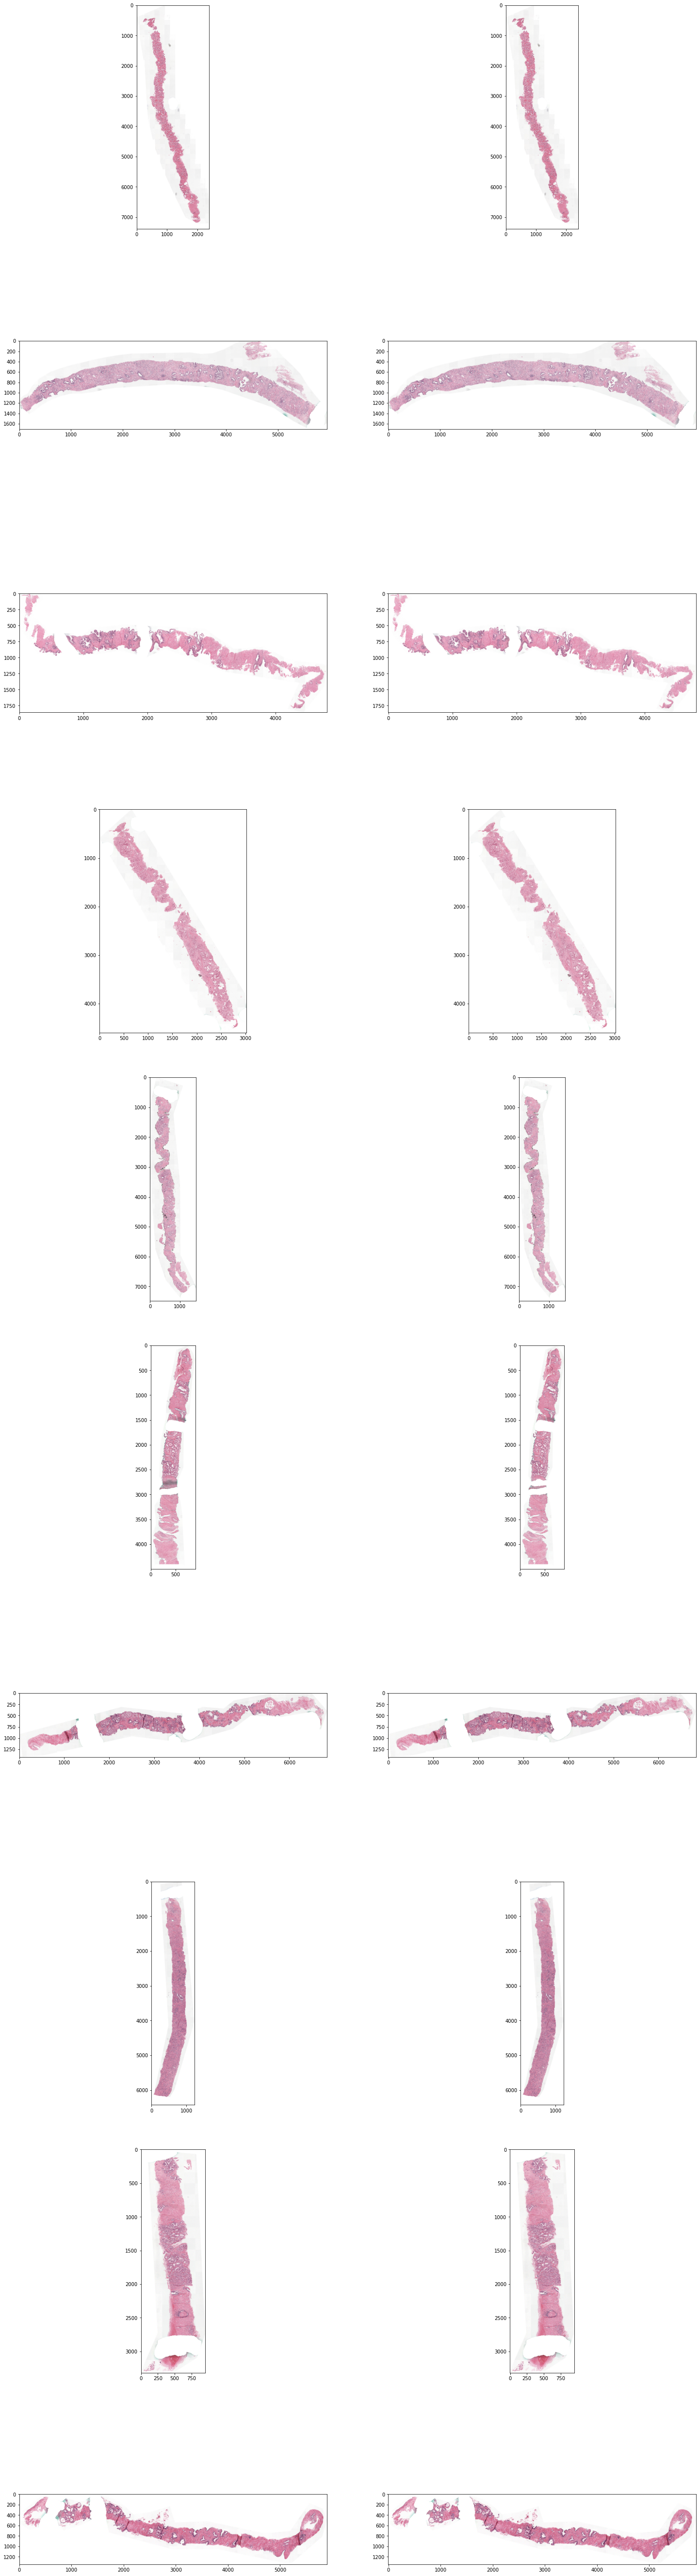

In [24]:
marked_images = np.load('../scripts/input_/marked_images.npy', allow_pickle=True)
path = DataManager.get_path() + 'train_images/'

paths = path + marked_images + '.jpeg'

fig, axes = plt.subplots(10, 2, figsize=(25, 100))

for i, ax in enumerate(axes):
    image = read_image(paths[i*5]) # just for debugging
    image_masked = remove_penmarks(paths[i*5])
    axes[i,0].imshow(image)
    axes[i,1].imshow(image_masked);